In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./utae-paps')
from src.backbones import utae_mod
from src.learning.weight_init import weight_init


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 17
BATCH_SIZE = 1

In [5]:
SATELLITE_ZARR_PATH = 'data/full/eumetsat_seviri_hrv_uk.zarr/'

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


In [6]:
BATCH_SIZE = 1
ds = climatehack_dataset.ClimatehackDataset(dataset, random_state=7)
ch_dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
#     num_workers=4,
#     prefetch_factor=4,
)

In [7]:
x, y_groups, x_last, y = ds[0]

In [8]:
x.shape, y_groups.shape, x_last.shape, y.shape

((12, 128, 128), (24, 64, 64), (128, 128), (24, 64, 64))

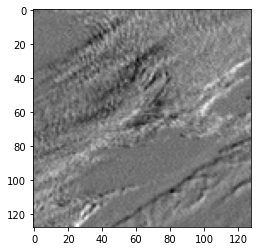

In [9]:
plt.imshow(x[-2], cmap='gray')

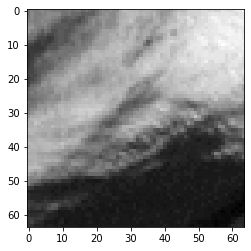

In [10]:
plt.imshow(y[0], cmap='gray')

In [11]:
model = utae_mod.UTAE(
    forecast_steps=FORECAST,
    input_dim=1, # 10 for paper
    encoder_widths=[64, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, 81],
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=None, # 0
    padding_mode="reflect",
)

# model = model.apply(weight_init)
print("USING 256")
model.load_state_dict(torch.load("weights/300d_imagediff_forecast=17_full/utae_epochs=256_loss=4.0607.pt"))
model = model.to(DEVICE)

USING 256


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 1099601 trainable parameters


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 1e-3
criterion = torch.nn.CrossEntropyLoss()

In [14]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()

    epoch_loss = 0
    total_count = 0
    pbar = tqdm.tqdm(dl)
    optimizer.zero_grad()
    
    true_batch_size = 8
    for i, (srcs, trgs, _, _) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs[:,:FORECAST].long().to(DEVICE)
        x = torch.unsqueeze(x, dim=2)

        preds = model(x)
        b, t, k, w, h = preds.shape
        preds_flat = preds.reshape(b*t, k, w, h)
        y_flat = y.reshape(b*t, w, h)
        loss = criterion(preds_flat, y_flat)
        loss.backward()
        
        if i % true_batch_size == true_batch_size - 1:
            # gradients are accumulated until here
            optimizer.step()
            optimizer.zero_grad()
      
        ls = loss.item()
        epoch_loss += ls
        total_count += len(srcs)
        if i % 1 == 0:
            ls = round(ls/len(srcs), 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 2000 == 1999:
                torch.save(model.state_dict(), f'weights/300d_imagediff_forecast=17_full/utae_epochs={epoch}_batch={i}_loss={avg_loss}.pt')
    
    # do a final update
    optimizer.step()
    optimizer.zero_grad()
    return epoch_loss / total_count



In [15]:
EPOCHS = 1000
EXISTING = 256

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, ch_dataloader, optimizer, criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/300d_imagediff_forecast=17_full/utae_epochs={i}_loss={avg_loss}.pt')
    

Epoch 257


Avg Loss, Batch Loss: (4.0683, 4.0449): 100%|██████████| 676/676 [26:25<00:00,  2.35s/it]


Epoch 258


Avg Loss, Batch Loss: (4.0628, 4.0341): 100%|██████████| 676/676 [26:24<00:00,  2.34s/it]


Epoch 259


Avg Loss, Batch Loss: (4.068, 4.1237): 100%|██████████| 676/676 [26:26<00:00,  2.35s/it] 


Epoch 260


Avg Loss, Batch Loss: (4.0669, 4.0021): 100%|██████████| 676/676 [26:29<00:00,  2.35s/it]


Epoch 261


Avg Loss, Batch Loss: (4.0637, 3.9455): 100%|██████████| 676/676 [26:29<00:00,  2.35s/it]


Epoch 262


Avg Loss, Batch Loss: (4.068, 3.9922): 100%|██████████| 676/676 [26:25<00:00,  2.34s/it] 


Epoch 263


Avg Loss, Batch Loss: (4.0643, 3.9678): 100%|██████████| 676/676 [26:30<00:00,  2.35s/it]


Epoch 264


Avg Loss, Batch Loss: (4.0741, 4.0677): 100%|██████████| 676/676 [26:31<00:00,  2.35s/it]


Epoch 265


Avg Loss, Batch Loss: (4.0673, 4.0241): 100%|██████████| 676/676 [26:29<00:00,  2.35s/it]


Epoch 266


Avg Loss, Batch Loss: (4.0617, 4.0111): 100%|██████████| 676/676 [26:33<00:00,  2.36s/it]


Epoch 267


Avg Loss, Batch Loss: (4.0628, 3.8825): 100%|██████████| 676/676 [26:29<00:00,  2.35s/it]


Epoch 268


Avg Loss, Batch Loss: (4.0709, 4.0448): 100%|██████████| 676/676 [26:23<00:00,  2.34s/it]


Epoch 269


Avg Loss, Batch Loss: (4.064, 4.0232): 100%|██████████| 676/676 [26:28<00:00,  2.35s/it] 


Epoch 270


Avg Loss, Batch Loss: (4.0703, 4.1402): 100%|██████████| 676/676 [26:26<00:00,  2.35s/it]


Epoch 271


Avg Loss, Batch Loss: (4.0604, 3.9239): 100%|██████████| 676/676 [26:25<00:00,  2.35s/it]


Epoch 272


Avg Loss, Batch Loss: (4.0658, 3.9323): 100%|██████████| 676/676 [26:24<00:00,  2.34s/it]


Epoch 273


Avg Loss, Batch Loss: (4.0676, 4.0753): 100%|██████████| 676/676 [26:29<00:00,  2.35s/it]


Epoch 274


Avg Loss, Batch Loss: (4.0659, 4.058): 100%|██████████| 676/676 [26:27<00:00,  2.35s/it] 


Epoch 275


Avg Loss, Batch Loss: (4.0627, 4.1908): 100%|██████████| 676/676 [26:32<00:00,  2.36s/it]


Epoch 276


Avg Loss, Batch Loss: (4.0667, 4.0172): 100%|██████████| 676/676 [26:30<00:00,  2.35s/it]


Epoch 277


Avg Loss, Batch Loss: (4.0728, 4.2554): 100%|██████████| 676/676 [26:37<00:00,  2.36s/it]


Epoch 278


Avg Loss, Batch Loss: (4.0771, 4.0494):   3%|▎         | 21/676 [00:53<27:36,  2.53s/it]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), f'weights/300d_imagediff_forecast=17/initial.pt')
